In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt

In [2]:
data = np.load("../data/processed/BankChurners_processed.npy", allow_pickle=True)

In [3]:
data

array([(0, '0', 0, '1', 0, '3', '1', '2', '0', 0, 0, 0, 0, 0.34018992, 0, 0.34511633, 0.39299382, 0, 0, 0.43753366, 0.06106106),
       (0, '0', 0, '0', 1, '2', '2', '4', '0', 0, 1, 0, 0, 0.20611167, 0, 0.21409324, 0.45363556, 0, 0, 1.        , 0.10510511),
       (0, '0', 0, '1', 0, '2', '1', '3', '0', 0, 0, 0, 0, 0.05984999, 0, 0.09894822, 0.76361495, 0, 0, 0.6281637 , 0.        ),
       ...,
       (0, '1', 0, '0', 0, '3', '1', '4', '0', 0, 0, 0, 0, 0.1200416 , 0, 0.15663663, 0.24109508, 0, 0, 0.22024771, 0.        ),
       (0, '1', 0, '1', 0, '2', '3', '1', '0', 0, 0, 0, 0, 0.11617192, 0, 0.15292788, 0.1574919 , 0, 0, 0.19439957, 0.        ),
       (0, '1', 0, '0', 0, '2', '1', '4', '3', 0, 1, 0, 0, 0.27056597, 0, 0.24408194, 0.20694731, 0, 0, 0.17474421, 0.18918919)],
      dtype=[('CLIENTNUM', '<i4'), ('Attrition_Flag', '<U20'), ('Customer_Age', '<i4'), ('Gender', '<U10'), ('Dependent_count', '<i4'), ('Education_Level', '<U30'), ('Marital_Status', '<U20'), ('Income_Category', 

In [4]:
X_columns = ['Customer_Age', 'Gender', 'Dependent_count', 'Education_Level', 'Marital_Status', 'Income_Category',
 'Card_Category', 'Months_on_book', 'Total_Relationship_Count', 'Months_Inactive_12_mon', 'Contacts_Count_12_mon',
 'Credit_Limit', 'Total_Revolving_Bal', 'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
 'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio']

In [5]:
def minmax_scaler(X):
    X = X.astype(float)

    X_min = X.min(axis=0)
    X_max = X.max(axis=0)

    diff = X_max - X_min
    diff[diff == 0] = 1  

    X_scaled = (X - X_min) / diff
    return X_scaled

In [6]:
y = data["Attrition_Flag"]
y = y.astype(float)
X = data[X_columns]
X_matrix = np.vstack([list(row) for row in X])
X_matrix = X_matrix.astype(float)
X_scaled = minmax_scaler(X_matrix)
X_b = np.hstack((np.ones((data.shape[0],1)), X_scaled))
X_b

array([[1.        , 0.        , 1.        , ..., 0.        , 0.43753366,
        0.06106106],
       [1.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.10510511],
       [1.        , 0.        , 1.        , ..., 0.        , 0.6281637 ,
        0.        ],
       ...,
       [1.        , 0.        , 0.        , ..., 0.        , 0.22024771,
        0.        ],
       [1.        , 0.        , 1.        , ..., 0.        , 0.19439957,
        0.        ],
       [1.        , 0.        , 0.        , ..., 0.        , 0.17474421,
        0.18918919]])

In [21]:
values, counts = np.unique(y, return_counts=True)

for i in range(len(values)):
    print(f"{values[i].astype(int)}: {counts[i]/len(y) * 100}")

0: 83.934037720944
1: 16.065962279055988


In [ ]:
def sigmoid(z):
    return 1/(1 + np.exp(-z))

def predict(X, theta):
    z = np.dot(X, theta)
    return sigmoid(z)

def compute_loss(y_hat, y):
    return -y.T.dot(np.log(y_hat)) - (1-y).T.dot(np.log(1 - y_hat))

def compute_gradient(X, y_hat, y):
    return X.T.dot(y_hat - y)

def update_gradient(theta, learning_rate, gradient):
    theta -= learning_rate*gradient
    return theta

def predict_label(y_hat, threshold = 0.3):
    y_pred = (y_hat >= threshold).astype(int)
    return y_pred

def accuracy(y_hat, y):
    y_pred = predict_label(y_hat)
    return np.mean(y == y_pred)

def evaluate(y_pred, y):
    TP = np.sum((y == 1) & (y_pred == 1))
    TN = np.sum((y == 0) & (y_pred == 0))
    FP = np.sum((y == 0) & (y_pred == 1))
    FN = np.sum((y == 1) & (y_pred == 0))

    precision = TP / (TP + FP) if (TP + FP) != 0 else 0
    recall = TP / (TP + FN) if (TP + FN) != 0 else 0

    if precision + recall == 0:
        f1_score = 0
    else:
        f1_score = 1 / (1/precision + 1/recall)

    confu_matrix = np.array([
        [TN, FP],
        [FN, TP]
    ])
    
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-score: {f1_score}")
    print(f"Confusion matrix: {confu_matrix}")

In [9]:
def train_val_test_split(X, y, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, shuffle=True):
    m = X.shape[0]

    if shuffle:
        idx = np.random.permutation(m)
        X = X[idx]
        y = y[idx]

    train_end = int(train_ratio * m)
    val_end = train_end + int(val_ratio * m)

    X_train = X[:train_end]
    y_train = y[:train_end]

    X_val = X[train_end:val_end]
    y_val = y[train_end:val_end]

    X_test = X[val_end:]
    y_test = y[val_end:]

    return X_train, y_train, X_val, y_val, X_test, y_test

In [10]:
X_train, y_train, X_val, y_val, X_test, y_test = train_val_test_split(X_b, y)

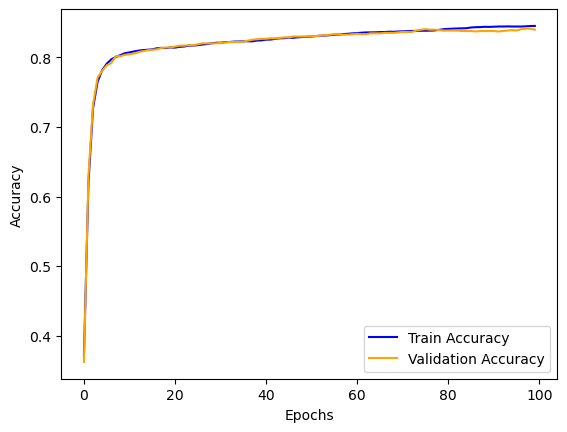

In [11]:
np.random.seed(42)
n_features = X_train.shape[1]
N = X_train.shape[0]
theta = np.asarray(np.random.randn(n_features))
n_epochs = 100
minibatch_size = 256
learning_rate = 0.05
losses = []
train_acc = []
val_acc = []

for epoch in range(n_epochs):
    np.random.seed(42)
    shuffled_indices = np.random.permutation(N)
    X_b_shuffled = X_train[shuffled_indices]
    y_shuffled = y_train[shuffled_indices]

    for i in range(0, N, minibatch_size):
        batch = min(i + minibatch_size, N)
        xi = X_b_shuffled[i:batch]
        yi = y_shuffled[i:batch]

        y_hat = predict(xi, theta)

        batch_real = len(yi)
        loss = compute_loss(y_hat, yi) / batch_real
        losses.append(loss)

        gradient = compute_gradient(xi, y_hat, yi) / batch_real

        theta = update_gradient(theta, learning_rate, gradient)
    y_hat_train = predict(X_train, theta)    
    #print(f"Accuracy train: {accuracy(y_hat_train, y_train)}")
    train_acc.append(accuracy(y_hat_train, y_train))
    y_hat_val = predict(X_val, theta)
    #print(f"Accuracy val: {accuracy(y_hat_val, y_val)}")
    val_acc.append(accuracy(y_hat_val, y_val))

plt.plot(train_acc, color='blue',  markersize=4, label='Train Accuracy')
plt.plot(val_acc,   color='orange', markersize=4, label='Validation Accuracy')

plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()



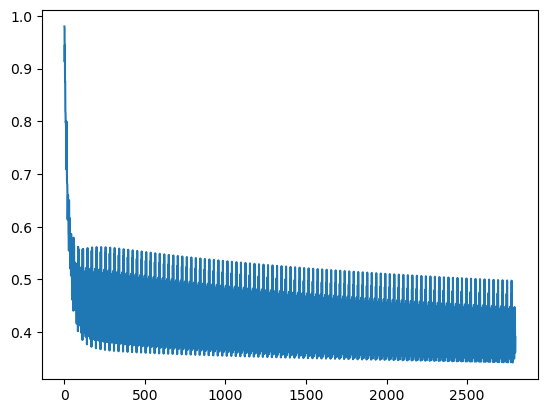

In [12]:
plt.plot(losses)

In [15]:
y_hat_test = predict(X_test, theta)
print(f"Accuracy test: {accuracy(y_hat_test, y_test)}")

Accuracy test: 0.8486842105263158


In [16]:
y_pred_test = predict_label(y_hat_test)
evaluate(y_pred_test, y_test)

Precision: 0.5585585585585585
Recall: 0.2551440329218107
F1-score: 0.3502824858757062
Confusion matrix: [[1228   49]
 [ 181   62]]
